# CORDEX / CMIP5 xarray cartopy vis example: Overlay regional on global grid
- see DKRZ visualization example; https://docs.dkrz.de/doc/visualization/sw/python/ 
    - especially https://docs.dkrz.de/doc/visualization/sw/python/source_code/python-matplotlib-example-overlay-regional-on-global-grid.html

In [ ]:
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
#global data:
mname1 = "/pool/data/CMIP5/data/cmip5/output1/MPI-M/MPI-ESM-LR/rcp26/fx/atmos/fx/r0i0p0/v20111014/sftlf/sftlf_fx_MPI-ESM-LR_rcp26_r0i0p0.nc"
fname1 = "/pool/data/CMIP5/data/cmip5/output1/MPI-M/MPI-ESM-LR/rcp26/fx/atmos/fx/r0i0p0/v20111014/orog/orog_fx_MPI-ESM-LR_rcp26_r0i0p0.nc"


#regional data:
fname2 = "/pool/data/CORDEX/data/cordex/output/EUR-11/MPI-CSC/MPI-M-MPI-ESM-LR/historical/r0i0p0/MPI-CSC-REMO2009/v1/fx/orog/v20160419/orog_EUR-11_MPI-M-MPI-ESM-LR_historical_r0i0p0_MPI-CSC-REMO2009_v1_fx.nc"
mname2 = "/pool/data/CORDEX/data/cordex/output/EUR-11/MPI-CSC/MPI-M-MPI-ESM-LR/historical/r0i0p0/MPI-CSC-REMO2009/v1/fx/sftlf/v20160419/sftlf_EUR-11_MPI-M-MPI-ESM-LR_historical_r0i0p0_MPI-CSC-REMO2009_v1_fx.nc"

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


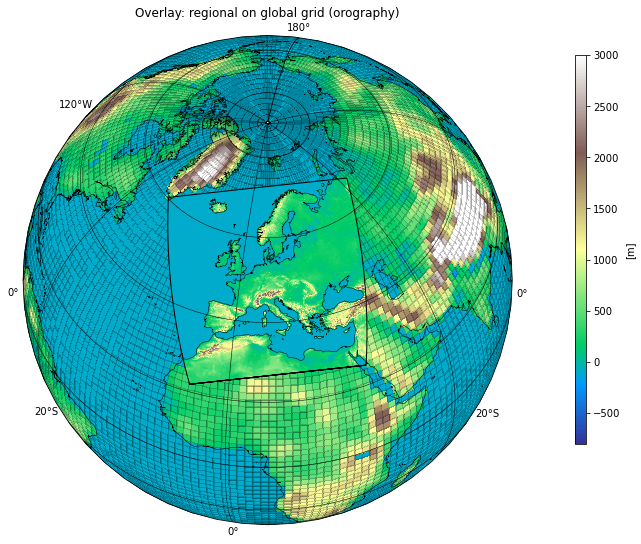

In [5]:
 #--  open file and read variables
f1    =  xr.open_dataset(fname1)
var1  =  f1.variables["orog"][:,:]

mask1 =  xr.open_dataset(mname1)
lsm1  =  mask1.variables["sftlf"][:,:]
lsm1  =  np.where(lsm1 > 0.5, lsm1, 0)

land_only1 = np.where(lsm1 > 0.5, var1, -101)    #-- min contour value - 1

lat   =  f1.variables["lat"][:]
lon   =  f1.variables["lon"][:]
dlat  =  lat[1]-lat[0]
dlon  =  lon[1]-lon[0]

 #-- Add cyclic points:

cyclic_data, cyclic_lon = cutil.add_cyclic_point(land_only1, coord=lon)

f2    = xr.open_dataset(fname2)
var2  = f2.variables["orog"][:,:]

mask2 = xr.open_dataset(mname2)
lsm2  = mask2.variables["sftlf"][:,:]
lsm2  = np.where(lsm2 > 0.5, lsm2, 0)

land_only2 = np.where(lsm2 > 0.5, var2, -101)    #-- min contour value - 1

lat2d = f2.variables["lat"][:,:]
lon2d = f2.variables["lon"][:,:]

nlat  = len(lat2d[:,0])
nlon  = len(lon2d[0,:])

    #-- Define edges of regional data:

lon_val_lower = lon2d[0,:]
lon_val_right = lon2d[:,nlon-1]
lon_val_left  = lon2d[:,0]
lon_val_upper = lon2d[nlat-1,:]

lat_val_lower = lat2d[0,:]
lat_val_right = lat2d[:,nlon-1]
lat_val_left  = lat2d[:,0]
lat_val_upper = lat2d[nlat-1,:]

    #-- Generate the data for the edges of the regional grid

line_lons = np.append([lon_val_upper], [lon_val_right[::-1]])
line_lons = np.append([line_lons], [lon_val_lower])
line_lons = np.append([line_lons], [lon_val_left])
line_lats = np.append([lat_val_upper], [lat_val_right[::-1]])
line_lats = np.append([line_lats], [lat_val_lower])
line_lats = np.append([line_lats], [lat_val_left])

polyline = np.column_stack([line_lons, line_lats])

    #-- Create the color mesh plot:

projection=ccrs.Orthographic(central_latitude=50.0, central_longitude=10.0)

fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10,9))

ax.set_global()

    #-- add coastal outlines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='k', zorder=3)
gl.xlabel_style = {'size':10}
gl.ylabel_style = {'size':10}
gl.top_labels   = True
gl.right_labels = True

    #-- plot the title string
plt.title('Overlay: regional on global grid (orography)')

    #-- define color map
cmap = 'terrain'

    #-- create the color mesh plot
edgecolor = [0.0, 0.0, 0.0, 0.2] #'k'
linewidth = 0.005

cnf1  = ax.pcolormesh(cyclic_lon, lat, cyclic_data,
                          cmap=cmap,
                          vmin=-800,
                          vmax=3000,
                          edgecolor=edgecolor,
                          linewidth=linewidth,
                          transform=ccrs.PlateCarree())

cnf2 = ax.pcolormesh(lon2d, lat2d, land_only2,
                         cmap=cmap,
                         vmin=-800,
                         vmax=3000,
                         transform=ccrs.PlateCarree())

    #-- add a polyline around the regional grid
lw, ec, fc = 1, 'k', 'y'     #-- linewidth, edgecolor, facecolor

ax.add_patch(mpatches.Polygon(polyline,
                                  closed=False,
                                  fill=False,
                                  linewidth=lw,
                                  edgecolor=ec,
                                  facecolor=fc,
                                  transform=ccrs.Geodetic()))

    #-- add a color bar
cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.6], autoscalex_on=True)  #-- x,y,w,h
cbar    = fig.colorbar(cnf1, cax=cbar_ax, orientation='vertical')
plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
cbar.set_label('[m]')

    #-- save the plot in PNG format
plt.savefig('grid_resolutions_overlay.png', bbox_inches='tight', dpi=100)